### Explore GlobalNEWS Alkalinity river input data, total up Alk inputs, modify files for OAE 
## Case 2: 5 Gt CO2/yr * 5 Gt/3.3Gt (the ratio of what we want versus what we got from the model) * 27.27 ALK/Gt CO2 / 100 sites =  2.066  Tmol/site/year    ( 206.6 Tmol total)

 Kristen, if you're picking 100 sites, can you make sure some are located in the northern Gulf of Guinea (W. Africa)? There's a good site for mEWR there. If you need help picking sites, let me know. At this point, I think we're just stippling all over the place. Maybe no more than 1 or 2 sites in Baltic or Med as those are going to be especially spicy due to the restricted circulation (similar to Persian Gulf).

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath
import cmocean
import cftime
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

In [2]:
ds_globalnews = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/ocn/pop/gx1v7/forcing/riv_nut.gnews_gnm.gx1v7_nn_open_ocean_nnsm_e1000r300_marginal_sea.20170425.nc')

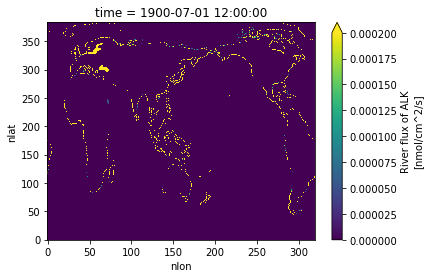

In [3]:
ds_globalnews.alk_riv_flux.isel(time=0).plot(vmin=0,vmax=0.0002)

In [4]:
df_sites = pd.read_csv('OAE_Site_Map_Redacted_Final.csv')
df_sites.loc[0]#['Latitude (N)']

Site Name        Salish Sea/Puget Sound
Latitude (N)                      48.25
Longitude (E)                    -123.4
Name: 0, dtype: object

In [5]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)
area_km2 = area * 1e-10

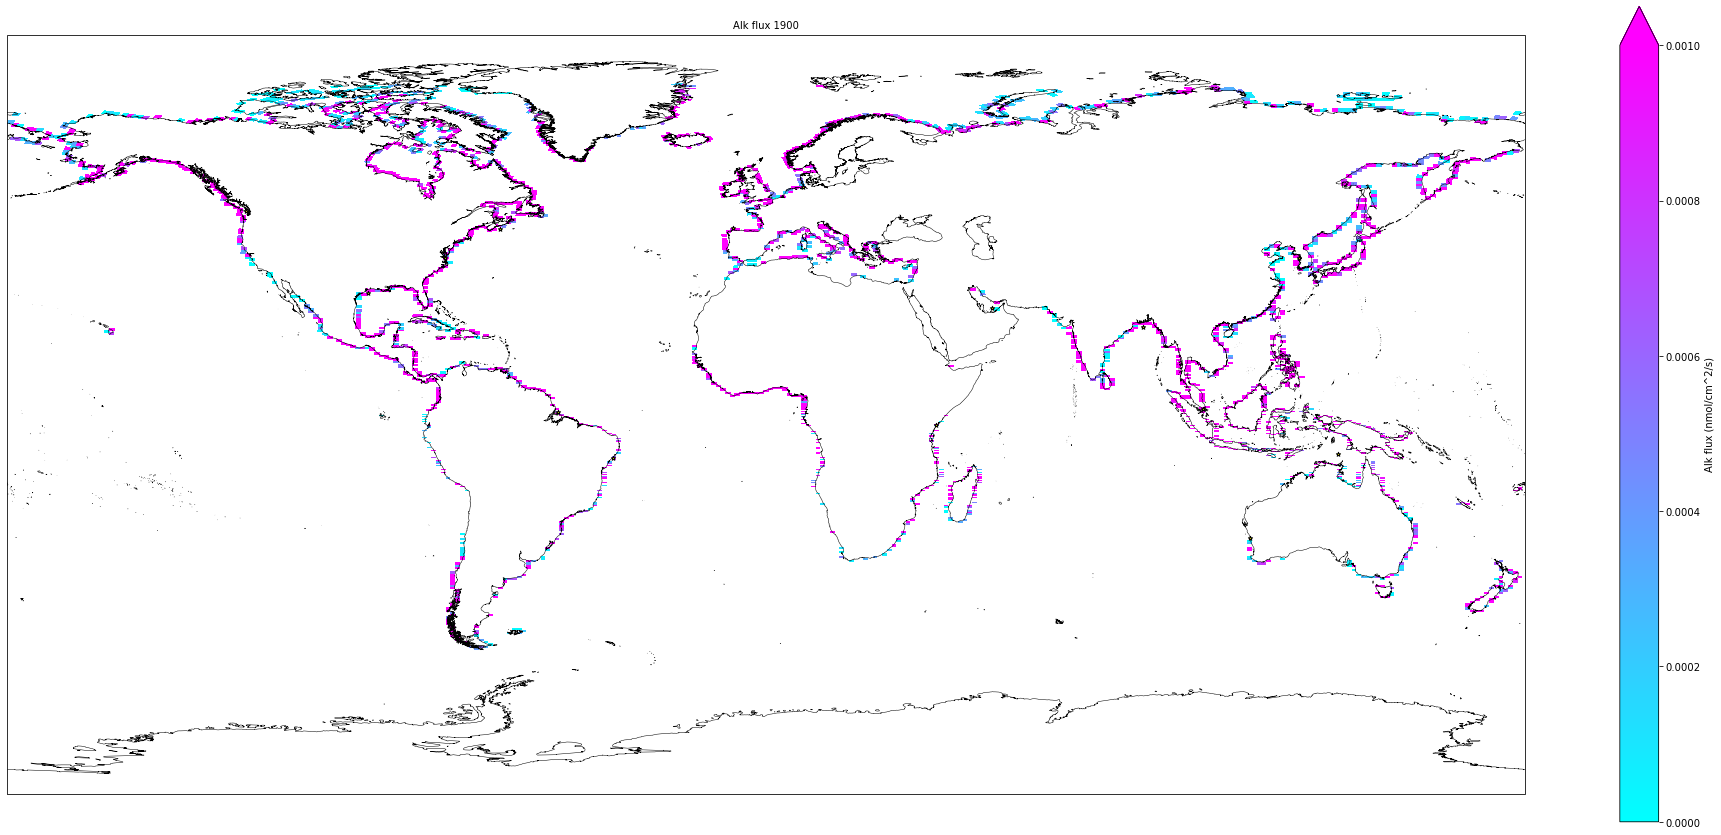

In [6]:
fig = plt.figure(figsize=(34,15))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0)
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.001, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=20,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())



cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol/cm^2/s)')

fig.savefig('/glade/work/kristenk/figs/River_map.png', bbox_inches='tight', dpi=300, format='png');


### Total up natural global alk flux

In [7]:
alk_tmp = ds_globalnews.alk_riv_flux * area # unit = nmol Alk per second per gridcell

In [8]:
alk_tmp2 = alk_tmp * 86400. * 365 * 1e-9 # unit = mol Alk per year per gridcell

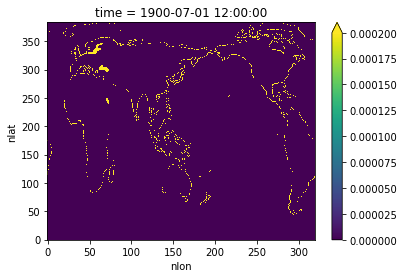

In [9]:
alk_tmp2.isel(time=0).plot(vmin=0,vmax=0.0002)

In [10]:
alk_glb_tot = alk_tmp2.sum(dim=('nlat','nlon'))

In [11]:
alk_glb_totC = alk_glb_tot * 1e-15 * 12.011 # unit = Pg carbon alk equivalents per year
alk_glb_totC

<xarray.DataArray (time: 21)>
array([0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881])
Coordinates:
  * time     (time) object 1900-07-01 12:00:00 ... 2000-07-01 12:00:00

In [12]:
alk_glb_Tmol = alk_glb_tot * 1e-12
alk_glb_Tmol

<xarray.DataArray (time: 21)>
array([22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128])
Coordinates:
  * time     (time) object 1900-07-01 12:00:00 ... 2000-07-01 12:00:00

### 0.022 Pmol (22 Tmol) natural Alkalinity flux from rivers per year

In [13]:
nat_alk_flux = ds_globalnews.alk_riv_flux.isel(time=0) #.where(ds_grid.REGION_MASK>0)
nat_alk_flux = nat_alk_flux.where(nat_alk_flux > 0) * area * 86400. * 365  * 1e-9 # unit = nmol Alk per year per gridcell
nat_alk_glb_tot = nat_alk_flux.sum(dim=('nlat','nlon')) * 1.e-12
nat_alk_glb_tot

<xarray.DataArray ()>
array(22.04719128)
Coordinates:
    time     object 1900-07-01 12:00:00

In [14]:
### empty ones mask to use for making masks for each region

ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

### 100 regions for OAE 

##### 5Gt CO2/yr is reasonable (even ambitious) for any one CDR pathway and 2 Gt CO2/yr seems like it's probably a pragmatic amount

In [147]:
######## Choose 4 North American regions

### REGION 1: Salish Sea/Puget Sound
box1_latmin = 47
box1_latmax = 49
box1_lonmin = -126.
box1_lonmax = -122.

### REGION 16: British Columbia near Hecate Strait
box16_latmin = 52
box16_latmax = 55
box16_lonmin = -133.
box16_lonmax = -128.

### REGION 17: oregon coast, a bit of N CA
box17_latmin = 41
box17_latmax = 44
box17_lonmin = -126.
box17_lonmax = -122.

### REGION 18: central california coast, near San Francisco
box18_latmin = 36
box18_latmax = 39
box18_lonmin = -124.
box18_lonmax = -121.

### REGION 19: around Los Angeles
box19_latmin = 32
box19_latmax = 34
box19_lonmin = -119.
box19_lonmax = -117.

### REGION 2: Gulf of Mexico, near Houston
box2_latmin = 28
box2_latmax = 30
box2_lonmin = -96.
box2_lonmax = -93.

### REGION 20: Gulf of Mexico, Mississippi delta
box20_latmin = 29
box20_latmax = 31
box20_lonmin = -91.
box20_lonmax = -87.

### REGION 3: Norfolk VA
box3_latmin = 36
box3_latmax = 38
box3_lonmin = -78.
box3_lonmax = -75.

### REGION 4: Halifax Habour
box4_latmin = 43
box4_latmax = 46
box4_lonmin = -65.
box4_lonmax = -61.


### REGION 21: Bay of Campeche in the southern Caribbean
box21_latmin = 17.5
box21_latmax = 19.5
box21_lonmin = -95.
box21_lonmax = -92.

### REGION 91: Near Culiacan, Mexico (west coast)
box91_latmin = 24
box91_latmax = 27
box91_lonmin = -110.
box91_lonmax = -107.

### REGION 92: Near Peurto Vallarta , Mexico (west coast)
box92_latmin = 19
box92_latmax = 22
box92_lonmin = -107.
box92_lonmax = -104.

### REGION 93: Near Acapulco , Mexico (west coast)
box93_latmin = 16
box93_latmax = 18
box93_lonmin = -100.
box93_lonmax = -98.

### REGION 94: Near Guatemala City, Guatemala (west coast)
box94_latmin = 12.5
box94_latmax = 15
box94_lonmin = -93.
box94_lonmax = -89.

### REGION 95: Coastal Belize
box95_latmin = 15.5
box95_latmax = 18
box95_lonmin = -89.
box95_lonmax = -87.

### REGION 96: East coast of Mexico, into Caribbean
box96_latmin = 23
box96_latmax = 25
box96_lonmin = -98.
box96_lonmax = -95.

### REGION 97: West coast of Costa Rica
box97_latmin = 8.5
box97_latmax = 10.5
box97_lonmin = -86.5
box97_lonmax = -83.5

### REGION 98: North coast of Columbia, into Caribbean
box98_latmin = 10
box98_latmax = 12
box98_lonmin = -76
box98_lonmax = -73

### REGION 99: around Trinidad and Tabago
box99_latmin = 8
box99_latmax = 11
box99_lonmin = -62
box99_lonmax = -59

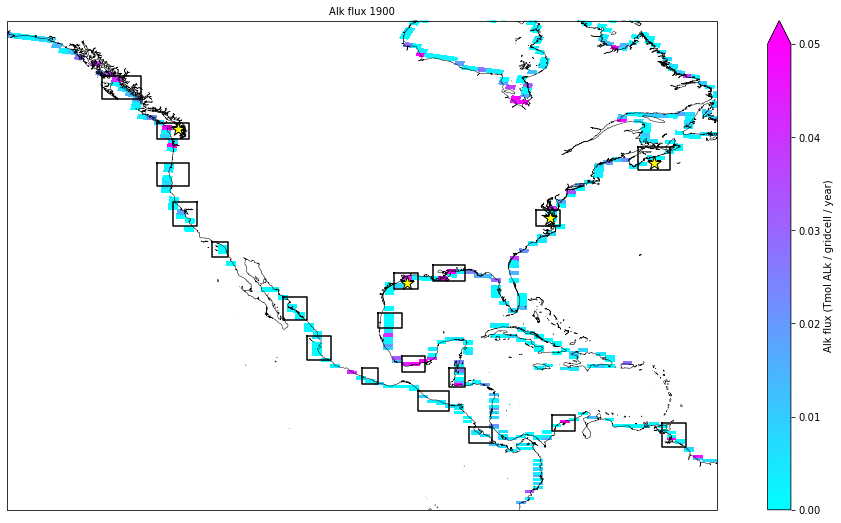

In [136]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-145, -55, 0, 62], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box16_lonmin,box16_lonmax,box16_lonmax,box16_lonmin,box16_lonmin]
lat_pts = [box16_latmax,box16_latmax,box16_latmin,box16_latmin,box16_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box17_lonmin,box17_lonmax,box17_lonmax,box17_lonmin,box17_lonmin]
lat_pts = [box17_latmax,box17_latmax,box17_latmin,box17_latmin,box17_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box18_lonmin,box18_lonmax,box18_lonmax,box18_lonmin,box18_lonmin]
lat_pts = [box18_latmax,box18_latmax,box18_latmin,box18_latmin,box18_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box19_lonmin,box19_lonmax,box19_lonmax,box19_lonmin,box19_lonmin]
lat_pts = [box19_latmax,box19_latmax,box19_latmin,box19_latmin,box19_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box20_lonmin,box20_lonmax,box20_lonmax,box20_lonmin,box20_lonmin]
lat_pts = [box20_latmax,box20_latmax,box20_latmin,box20_latmin,box20_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box21_lonmin,box21_lonmax,box21_lonmax,box21_lonmin,box21_lonmin]
lat_pts = [box21_latmax,box21_latmax,box21_latmin,box21_latmin,box21_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box91_lonmin,box91_lonmax,box91_lonmax,box91_lonmin,box91_lonmin]
lat_pts = [box91_latmax,box91_latmax,box91_latmin,box91_latmin,box91_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box92_lonmin,box92_lonmax,box92_lonmax,box92_lonmin,box92_lonmin]
lat_pts = [box92_latmax,box92_latmax,box92_latmin,box92_latmin,box92_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box93_lonmin,box93_lonmax,box93_lonmax,box93_lonmin,box93_lonmin]
lat_pts = [box93_latmax,box93_latmax,box93_latmin,box93_latmin,box93_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box94_lonmin,box94_lonmax,box94_lonmax,box94_lonmin,box94_lonmin]
lat_pts = [box94_latmax,box94_latmax,box94_latmin,box94_latmin,box94_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box95_lonmin,box95_lonmax,box95_lonmax,box95_lonmin,box95_lonmin]
lat_pts = [box95_latmax,box95_latmax,box95_latmin,box95_latmin,box95_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box96_lonmin,box96_lonmax,box96_lonmax,box96_lonmin,box96_lonmin]
lat_pts = [box96_latmax,box96_latmax,box96_latmin,box96_latmin,box96_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box97_lonmin,box97_lonmax,box97_lonmax,box97_lonmin,box97_lonmin]
lat_pts = [box97_latmax,box97_latmax,box97_latmin,box97_latmin,box97_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box98_lonmin,box98_lonmax,box98_lonmax,box98_lonmin,box98_lonmin]
lat_pts = [box98_latmax,box98_latmax,box98_latmin,box98_latmin,box98_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box99_lonmin,box99_lonmax,box99_lonmax,box99_lonmin,box99_lonmin]
lat_pts = [box99_latmax,box99_latmax,box99_latmin,box99_latmin,box99_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### Northeast Asia sites

In [124]:
### Let's put one in the Sea of Okhotsk

### REGION 22: Sea of Okhotsk
box22_latmin = 58
box22_latmax = 62
box22_lonmin = 155.
box22_lonmax = 162.

### REGION 23: East Sea - Sea of Japan
box23_latmin = 41
box23_latmax = 44
box23_lonmin = 129.
box23_lonmax = 134.

### REGION 81: Southern tip of Japan near Kagoshima
box81_latmin = 30
box81_latmax = 32
box81_lonmin = 129.
box81_lonmax = 132.5

### REGION 82: near Nagoya, Japan (Pacific side)
box82_latmin = 33.5
box82_latmax = 35.5
box82_lonmin = 136.5
box82_lonmax = 139

### REGION 83: near Sendai, Japan (Pacific side, north of Tokyo)
box83_latmin = 37
box83_latmax = 39
box83_lonmin = 140.5
box83_lonmax = 142.5

### REGION 84: near Niigata, Japan (Sea of Japan side)
box84_latmin = 36
box84_latmax = 38.5
box84_lonmin = 136
box84_lonmax = 139.5

### REGION 85: near Sapporo, Japan (Sea of Japan side)
box85_latmin = 42.5
box85_latmax = 45
box85_lonmin = 139.5
box85_lonmax = 142

### REGION 86: near Sakhalin into the Sea of Okhotsk
box86_latmin = 49.5
box86_latmax = 52.5
box86_lonmin = 143
box86_lonmax = 145

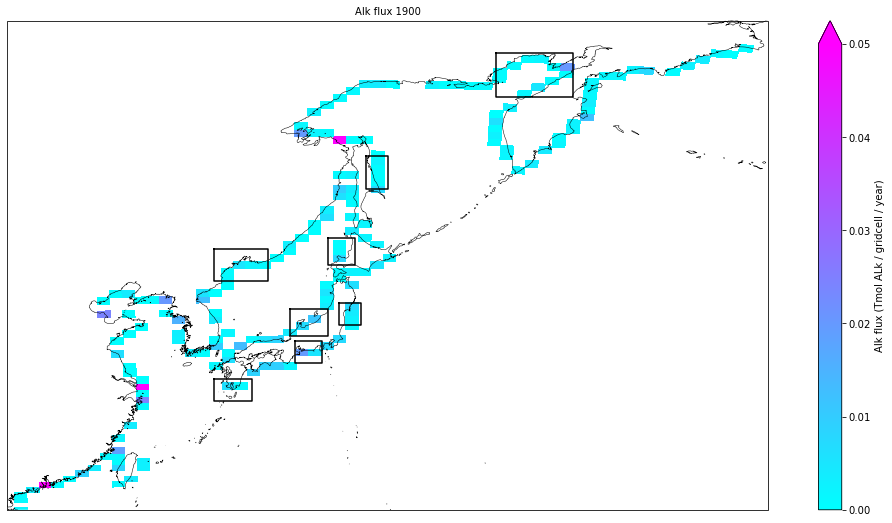

In [125]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([110, 180, 20, 65], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box22_lonmin,box22_lonmax,box22_lonmax,box22_lonmin,box22_lonmin]
lat_pts = [box22_latmax,box22_latmax,box22_latmin,box22_latmin,box22_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box23_lonmin,box23_lonmax,box23_lonmax,box23_lonmin,box23_lonmin]
lat_pts = [box23_latmax,box23_latmax,box23_latmin,box23_latmin,box23_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box81_lonmin,box81_lonmax,box81_lonmax,box81_lonmin,box81_lonmin]
lat_pts = [box81_latmax,box81_latmax,box81_latmin,box81_latmin,box81_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box82_lonmin,box82_lonmax,box82_lonmax,box82_lonmin,box82_lonmin]
lat_pts = [box82_latmax,box82_latmax,box82_latmin,box82_latmin,box82_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box83_lonmin,box83_lonmax,box83_lonmax,box83_lonmin,box83_lonmin]
lat_pts = [box83_latmax,box83_latmax,box83_latmin,box83_latmin,box83_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box84_lonmin,box84_lonmax,box84_lonmax,box84_lonmin,box84_lonmin]
lat_pts = [box84_latmax,box84_latmax,box84_latmin,box84_latmin,box84_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box85_lonmin,box85_lonmax,box85_lonmax,box85_lonmin,box85_lonmin]
lat_pts = [box85_latmax,box85_latmax,box85_latmin,box85_latmin,box85_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box86_lonmin,box86_lonmax,box86_lonmax,box86_lonmin,box86_lonmin]
lat_pts = [box86_latmax,box86_latmax,box86_latmin,box86_latmin,box86_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


## Northwest North America

In [126]:
### REGION 87: near Juneau, Alaska
box87_latmin = 56
box87_latmax = 59
box87_lonmin = -139
box87_lonmax = -135

### REGION 88: near Anchorage, Alaska
box88_latmin = 59.5
box88_latmax = 61.5
box88_lonmin = -149
box88_lonmax = -145

### REGION 89: near northeast side of Alaska peninsula
box89_latmin = 57
box89_latmax = 59
box89_lonmin = -159
box89_lonmax = -157

### REGION 90: mouth of Yukon river
box90_latmin = 61.5
box90_latmax = 64
box90_lonmin = -167
box90_lonmax = -164

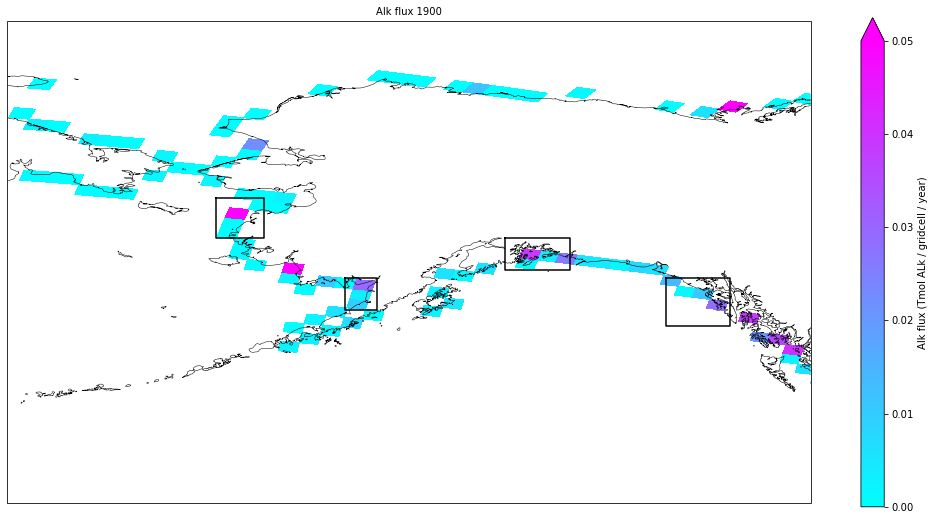

In [127]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -130, 45, 75], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())



lon_pts = [box87_lonmin,box87_lonmax,box87_lonmax,box87_lonmin,box87_lonmin]
lat_pts = [box87_latmax,box87_latmax,box87_latmin,box87_latmin,box87_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box88_lonmin,box88_lonmax,box88_lonmax,box88_lonmin,box88_lonmin]
lat_pts = [box88_latmax,box88_latmax,box88_latmin,box88_latmin,box88_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box89_lonmin,box89_lonmax,box89_lonmax,box89_lonmin,box89_lonmin]
lat_pts = [box89_latmax,box89_latmax,box89_latmin,box89_latmin,box89_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box90_lonmin,box90_lonmax,box90_lonmax,box90_lonmin,box90_lonmin]
lat_pts = [box90_latmax,box90_latmax,box90_latmin,box90_latmin,box90_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


In [134]:
### Choose a South american region

### REGION 5: At the Amazon
box5_latmin = -3
box5_latmax = 2
box5_lonmin = -51.
box5_lonmax = -47.

### REGION 6: Sao Francisco River
box6_latmin = -12
box6_latmax = -9
box6_lonmin = -38.
box6_lonmax = -34.

### REGION 24: Ecuador/Columbia border
box24_latmin = 0.5
box24_latmax = 4
box24_lonmin = -80.
box24_lonmax = -77.

### REGION 25: Uruguay/Argentina border
box25_latmin = -37
box25_latmax = -33
box25_lonmin = -59.
box25_lonmax = -53.

### REGION 26: Chile coast
box26_latmin = -46
box26_latmax = -41
box26_lonmin = -76.
box26_lonmax = -72.

### REGION 27: near San Paulo Brazil
box27_latmin = -25
box27_latmax = -22
box27_lonmin = -48.
box27_lonmax = -44.

### REGION 100: near Santiago, Chile
box100_latmin = -35
box100_latmax = -32
box100_lonmin = -73.
box100_lonmax = -70.

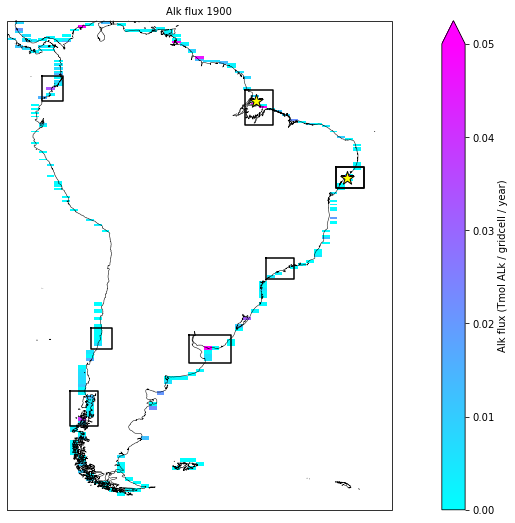

In [135]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -30, -58, 12], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box24_lonmin,box24_lonmax,box24_lonmax,box24_lonmin,box24_lonmin]
lat_pts = [box24_latmax,box24_latmax,box24_latmin,box24_latmin,box24_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box25_lonmin,box25_lonmax,box25_lonmax,box25_lonmin,box25_lonmin]
lat_pts = [box25_latmax,box25_latmax,box25_latmin,box25_latmin,box25_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box26_lonmin,box26_lonmax,box26_lonmax,box26_lonmin,box26_lonmin]
lat_pts = [box26_latmax,box26_latmax,box26_latmin,box26_latmin,box26_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box27_lonmin,box27_lonmax,box27_lonmax,box27_lonmin,box27_lonmin]
lat_pts = [box27_latmax,box27_latmax,box27_latmin,box27_latmin,box27_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box100_lonmin,box100_lonmax,box100_lonmax,box100_lonmin,box100_lonmin]
lat_pts = [box100_latmax,box100_latmax,box100_latmin,box100_latmin,box100_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


In [23]:
### Choose a European region

### REGION 7: Ortigueira estuary
box7_latmin = 43
box7_latmax = 45
box7_lonmin = -9
box7_lonmax = -7.

### REGION 8: Elbe Delta
box8_latmin = 53
box8_latmax = 55
box8_lonmin = 8
box8_lonmax = 10

### REGION 28: near Barcelona (Mediterranean)
box28_latmin = 40
box28_latmax = 42
box28_lonmin = 0
box28_lonmax = 3

### REGION 29: west coast of Greece (Mediterranean)
box29_latmin = 37
box29_latmax = 40
box29_lonmin = 19
box29_lonmax = 21.5

### REGION 30: near Bergen, Norway
box30_latmin = 59
box30_latmax = 61
box30_lonmin = 4
box30_lonmax = 6

### REGION 31: near Trondheim, Norway
box31_latmin = 62
box31_latmax = 64.5
box31_lonmin = 6
box31_lonmax = 10

### REGION 32: west coast of Ireland
box32_latmin = 52
box32_latmax = 54.5
box32_lonmin = -11.5
box32_lonmax = -9

### REGION 33: near Edinburgh
box33_latmin = 55
box33_latmax = 57
box33_lonmin = -3
box33_lonmax = -1

### REGION 34: Nantes, France
box34_latmin = 46
box34_latmax = 48
box34_lonmin = -4
box34_lonmax = -1

### REGION 35: Lisbon, Portugal
box35_latmin = 38
box35_latmax = 40
box35_lonmin = -11
box35_lonmax = -8

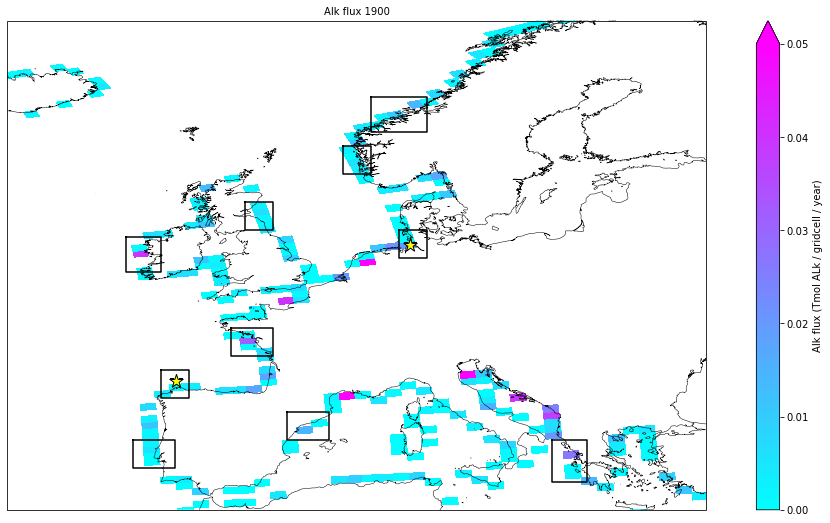

In [24]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 35, 70], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box7_lonmin,box7_lonmax,box7_lonmax,box7_lonmin,box7_lonmin]
lat_pts = [box7_latmax,box7_latmax,box7_latmin,box7_latmin,box7_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box8_lonmin,box8_lonmax,box8_lonmax,box8_lonmin,box8_lonmin]
lat_pts = [box8_latmax,box8_latmax,box8_latmin,box8_latmin,box8_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box28_lonmin,box28_lonmax,box28_lonmax,box28_lonmin,box28_lonmin]
lat_pts = [box28_latmax,box28_latmax,box28_latmin,box28_latmin,box28_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box29_lonmin,box29_lonmax,box29_lonmax,box29_lonmin,box29_lonmin]
lat_pts = [box29_latmax,box29_latmax,box29_latmin,box29_latmin,box29_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box30_lonmin,box30_lonmax,box30_lonmax,box30_lonmin,box30_lonmin]
lat_pts = [box30_latmax,box30_latmax,box30_latmin,box30_latmin,box30_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box31_lonmin,box31_lonmax,box31_lonmax,box31_lonmin,box31_lonmin]
lat_pts = [box31_latmax,box31_latmax,box31_latmin,box31_latmin,box31_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box32_lonmin,box32_lonmax,box32_lonmax,box32_lonmin,box32_lonmin]
lat_pts = [box32_latmax,box32_latmax,box32_latmin,box32_latmin,box32_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box33_lonmin,box33_lonmax,box33_lonmax,box33_lonmin,box33_lonmin]
lat_pts = [box33_latmax,box33_latmax,box33_latmin,box33_latmin,box33_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box34_lonmin,box34_lonmax,box34_lonmax,box34_lonmin,box34_lonmin]
lat_pts = [box34_latmax,box34_latmax,box34_latmin,box34_latmin,box34_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box35_lonmin,box35_lonmax,box35_lonmax,box35_lonmin,box35_lonmin]
lat_pts = [box35_latmax,box35_latmax,box35_latmin,box35_latmin,box35_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### Africa and Persian Gulf

In [25]:
### REGION 9: Tana River Delta Kenya
box9_latmin = -4.5
box9_latmax = -1
box9_lonmin = 39.
box9_lonmax = 43.

### REGION 10: Persian Gulf
box10_latmin = 24
box10_latmax = 30
box10_lonmin = 48.
box10_lonmax = 56.

### REGION 36: west coast of Senegal
box36_latmin = 13
box36_latmax = 15
box36_lonmin = -18
box36_lonmax = -15

### REGION 37: west coast Sierra Leone
box37_latmin = 6
box37_latmax = 8.5
box37_lonmin = -14
box37_lonmax = -11

### REGION 38: southern coast of Ivory Coast
box38_latmin = 4
box38_latmax = 6
box38_lonmin = -6
box38_lonmax = -3

### REGION 39: near Lagos, Nigeria
box39_latmin = 5
box39_latmax = 7
box39_lonmin = 2
box39_lonmax = 5

### REGION 40: near Warri, Nigeria
box40_latmin = 3
box40_latmax = 5.5
box40_lonmin = 5.5
box40_lonmax = 7.5

### REGION 41: near Douala, Cameroon
box41_latmin = 3
box41_latmax = 5
box41_lonmin = 8
box41_lonmax = 10

### REGION 42: off coast of equatorial guinea
box42_latmin = 0
box42_latmax = 2
box42_lonmin = 8
box42_lonmax = 10

### REGION 43: right around Port-Gentil, Gabon
box43_latmin = -2
box43_latmax = -0.5
box43_lonmin = 8
box43_lonmax = 10

### REGION 44: right around west coast of Angola
box44_latmin = -13
box44_latmax = -10
box44_lonmin = 12
box44_lonmax = 15

### REGION 45: around Cape Town
box45_latmin = -36
box45_latmax = -32
box45_lonmin = 17
box45_lonmax = 21

### REGION 46: around Maputo, in the south of Mozambique
box46_latmin = -27
box46_latmax = -24
box46_lonmin = 32
box46_lonmax = 36

### REGION 47: Around Beira Mozambique
box47_latmin = -21
box47_latmax = -18
box47_lonmin = 34
box47_lonmax = 37

### REGION 48: west side of Madagascar
box48_latmin = -21
box48_latmax = -18
box48_lonmin = 42
box48_lonmax = 45

### REGION 49: northeast side of Madagascar, near Masoala National Park
box49_latmin = -17
box49_latmax = -15
box49_lonmin = 49
box49_lonmax = 52

### REGION 50: southeast side of Madagascar
box50_latmin = -24.5
box50_latmax = -21.5
box50_lonmin = 47
box50_lonmax = 49.5

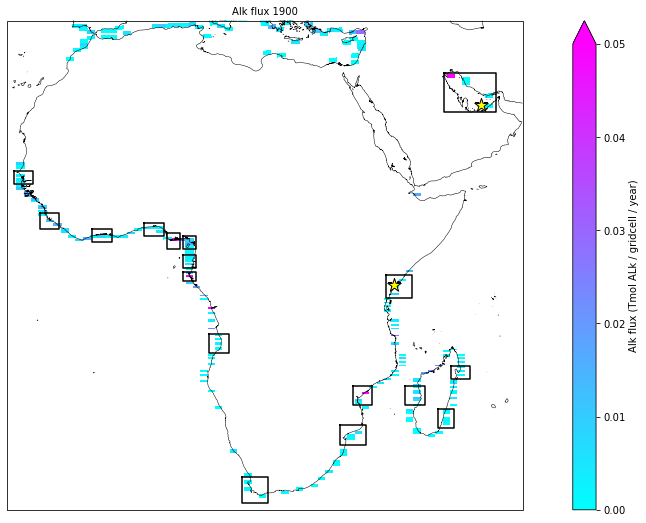

In [26]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-19, 60, -37, 38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box9_lonmin,box9_lonmax,box9_lonmax,box9_lonmin,box9_lonmin]
lat_pts = [box9_latmax,box9_latmax,box9_latmin,box9_latmin,box9_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box10_lonmin,box10_lonmax,box10_lonmax,box10_lonmin,box10_lonmin]
lat_pts = [box10_latmax,box10_latmax,box10_latmin,box10_latmin,box10_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box36_lonmin,box36_lonmax,box36_lonmax,box36_lonmin,box36_lonmin]
lat_pts = [box36_latmax,box36_latmax,box36_latmin,box36_latmin,box36_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box37_lonmin,box37_lonmax,box37_lonmax,box37_lonmin,box37_lonmin]
lat_pts = [box37_latmax,box37_latmax,box37_latmin,box37_latmin,box37_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box38_lonmin,box38_lonmax,box38_lonmax,box38_lonmin,box38_lonmin]
lat_pts = [box38_latmax,box38_latmax,box38_latmin,box38_latmin,box38_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box39_lonmin,box39_lonmax,box39_lonmax,box39_lonmin,box39_lonmin]
lat_pts = [box39_latmax,box39_latmax,box39_latmin,box39_latmin,box39_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box40_lonmin,box40_lonmax,box40_lonmax,box40_lonmin,box40_lonmin]
lat_pts = [box40_latmax,box40_latmax,box40_latmin,box40_latmin,box40_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box41_lonmin,box41_lonmax,box41_lonmax,box41_lonmin,box41_lonmin]
lat_pts = [box41_latmax,box41_latmax,box41_latmin,box41_latmin,box41_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box42_lonmin,box42_lonmax,box42_lonmax,box42_lonmin,box42_lonmin]
lat_pts = [box42_latmax,box42_latmax,box42_latmin,box42_latmin,box42_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box43_lonmin,box43_lonmax,box43_lonmax,box43_lonmin,box43_lonmin]
lat_pts = [box43_latmax,box43_latmax,box43_latmin,box43_latmin,box43_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box44_lonmin,box44_lonmax,box44_lonmax,box44_lonmin,box44_lonmin]
lat_pts = [box44_latmax,box44_latmax,box44_latmin,box44_latmin,box44_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box45_lonmin,box45_lonmax,box45_lonmax,box45_lonmin,box45_lonmin]
lat_pts = [box45_latmax,box45_latmax,box45_latmin,box45_latmin,box45_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box46_lonmin,box46_lonmax,box46_lonmax,box46_lonmin,box46_lonmin]
lat_pts = [box46_latmax,box46_latmax,box46_latmin,box46_latmin,box46_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box47_lonmin,box47_lonmax,box47_lonmax,box47_lonmin,box47_lonmin]
lat_pts = [box47_latmax,box47_latmax,box47_latmin,box47_latmin,box47_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box48_lonmin,box48_lonmax,box48_lonmax,box48_lonmin,box48_lonmin]
lat_pts = [box48_latmax,box48_latmax,box48_latmin,box48_latmin,box48_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box49_lonmin,box49_lonmax,box49_lonmax,box49_lonmin,box49_lonmin]
lat_pts = [box49_latmax,box49_latmax,box49_latmin,box49_latmin,box49_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box50_lonmin,box50_lonmax,box50_lonmax,box50_lonmin,box50_lonmin]
lat_pts = [box50_latmax,box50_latmax,box50_latmin,box50_latmin,box50_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### Asian regions: bay of bengal, singpore, yellow sea

In [27]:
### Let's put one in the Sea of Okhotsk

### REGION 11: Bay of Bengal
box11_latmin = 19
box11_latmax = 23
box11_lonmin = 88.
box11_lonmax = 92.

### REGION 12: Singapore
box12_latmin = 0
box12_latmax = 3
box12_lonmin = 101
box12_lonmax = 106

### REGION 13: Yellow Sea
box13_latmin = 35
box13_latmax = 40
box13_lonmin = 124
box13_lonmax = 128

### REGION 51: Near Karachi, India
box51_latmin = 23
box51_latmax = 25
box51_lonmin = 66
box51_lonmax = 69

### REGION 52: just north of Mumbai, India
box52_latmin = 18.5
box52_latmax = 21.5
box52_lonmin = 70
box52_lonmax = 73

### REGION 53: just north of Mumbai, India
box53_latmin = 12
box53_latmax = 15
box53_lonmin = 73
box53_lonmax = 75.5

### REGION 54: west side of Sri Lanka
box54_latmin = 6
box54_latmax = 8.5
box54_lonmin = 79
box54_lonmax = 80.5

### REGION 55: east side of Sri Lanka
box55_latmin = 6
box55_latmax = 9
box55_lonmin = 81
box55_lonmax = 83

### REGION 56: east side of Indian, near Vijayawada
box56_latmin = 14.5
box56_latmax = 17.5
box56_lonmin = 80
box56_lonmax = 83

### REGION 57: west side of Myanmar
box57_latmin = 16.5
box57_latmax = 19
box57_lonmin = 93.5
box57_lonmax = 95.5

### REGION 58: between Malaysia and Sumatra
box58_latmin = 3
box58_latmax = 6
box58_lonmin = 97
box58_lonmax = 101

### REGION 59: near Jakarta, in Java Sea
box59_latmin = -6.5
box59_latmax = -4
box59_lonmin = 105
box59_lonmax = 108

### REGION 60: near Bangkok
box60_latmin = 11.5
box60_latmax = 14
box60_lonmin = 99.5
box60_lonmax = 102.5

### REGION 61: near No Chi Minh City, Vietnam
box61_latmin = 9
box61_latmax = 11
box61_lonmin = 106
box61_lonmax = 109

### REGION 62: near Hanoi, Vietnam in Gulf of Tonkin
box62_latmin = 19
box62_latmax = 22
box62_lonmin = 106
box62_lonmax = 109

### REGION 63: near Hon Kong
box63_latmin = 21
box63_latmax = 23
box63_lonmin = 112
box63_lonmax = 115

### REGION 64: near Zhangzhou & Quanzhou, China, into Taiwan Strait
box64_latmin = 24
box64_latmax = 26
box64_lonmin = 118
box64_lonmax = 121

### REGION 65: around Shanghai
box65_latmin = 28.5
box65_latmax = 32.5
box65_lonmin = 121
box65_lonmax = 123.5

### REGION 66: near Brunei, a bit of Malaysia too, into South China Sea
box66_latmin = 3.5
box66_latmax = 5.5
box66_lonmin = 112.5
box66_lonmax = 116

### REGION 67: into the Celebes Sea from Malaysia
box67_latmin = 1
box67_latmax = 4
box67_lonmin = 117
box67_lonmax = 119

### REGION 68: Near Manilla, Phillipines
box68_latmin = 13
box68_latmax = 16
box68_lonmin = 121
box68_lonmax = 123.5

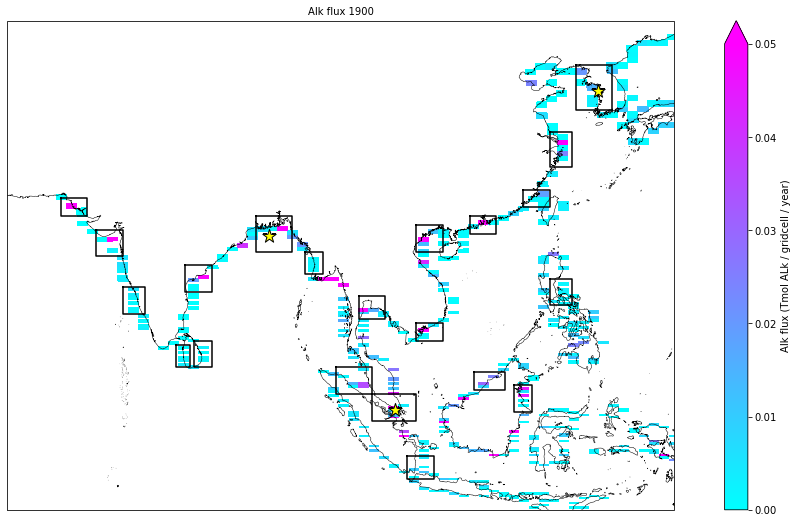

In [28]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([60, 135, -10, 45], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box11_lonmin,box11_lonmax,box11_lonmax,box11_lonmin,box11_lonmin]
lat_pts = [box11_latmax,box11_latmax,box11_latmin,box11_latmin,box11_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box12_lonmin,box12_lonmax,box12_lonmax,box12_lonmin,box12_lonmin]
lat_pts = [box12_latmax,box12_latmax,box12_latmin,box12_latmin,box12_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box13_lonmin,box13_lonmax,box13_lonmax,box13_lonmin,box13_lonmin]
lat_pts = [box13_latmax,box13_latmax,box13_latmin,box13_latmin,box13_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box51_lonmin,box51_lonmax,box51_lonmax,box51_lonmin,box51_lonmin]
lat_pts = [box51_latmax,box51_latmax,box51_latmin,box51_latmin,box51_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box52_lonmin,box52_lonmax,box52_lonmax,box52_lonmin,box52_lonmin]
lat_pts = [box52_latmax,box52_latmax,box52_latmin,box52_latmin,box52_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box53_lonmin,box53_lonmax,box53_lonmax,box53_lonmin,box53_lonmin]
lat_pts = [box53_latmax,box53_latmax,box53_latmin,box53_latmin,box53_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box54_lonmin,box54_lonmax,box54_lonmax,box54_lonmin,box54_lonmin]
lat_pts = [box54_latmax,box54_latmax,box54_latmin,box54_latmin,box54_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box55_lonmin,box55_lonmax,box55_lonmax,box55_lonmin,box55_lonmin]
lat_pts = [box55_latmax,box55_latmax,box55_latmin,box55_latmin,box55_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box56_lonmin,box56_lonmax,box56_lonmax,box56_lonmin,box56_lonmin]
lat_pts = [box56_latmax,box56_latmax,box56_latmin,box56_latmin,box56_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box57_lonmin,box57_lonmax,box57_lonmax,box57_lonmin,box57_lonmin]
lat_pts = [box57_latmax,box57_latmax,box57_latmin,box57_latmin,box57_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box58_lonmin,box58_lonmax,box58_lonmax,box58_lonmin,box58_lonmin]
lat_pts = [box58_latmax,box58_latmax,box58_latmin,box58_latmin,box58_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box59_lonmin,box59_lonmax,box59_lonmax,box59_lonmin,box59_lonmin]
lat_pts = [box59_latmax,box59_latmax,box59_latmin,box59_latmin,box59_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box60_lonmin,box60_lonmax,box60_lonmax,box60_lonmin,box60_lonmin]
lat_pts = [box60_latmax,box60_latmax,box60_latmin,box60_latmin,box60_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box61_lonmin,box61_lonmax,box61_lonmax,box61_lonmin,box61_lonmin]
lat_pts = [box61_latmax,box61_latmax,box61_latmin,box61_latmin,box61_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box62_lonmin,box62_lonmax,box62_lonmax,box62_lonmin,box62_lonmin]
lat_pts = [box62_latmax,box62_latmax,box62_latmin,box62_latmin,box62_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box63_lonmin,box63_lonmax,box63_lonmax,box63_lonmin,box63_lonmin]
lat_pts = [box63_latmax,box63_latmax,box63_latmin,box63_latmin,box63_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box64_lonmin,box64_lonmax,box64_lonmax,box64_lonmin,box64_lonmin]
lat_pts = [box64_latmax,box64_latmax,box64_latmin,box64_latmin,box64_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box65_lonmin,box65_lonmax,box65_lonmax,box65_lonmin,box65_lonmin]
lat_pts = [box65_latmax,box65_latmax,box65_latmin,box65_latmin,box65_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box66_lonmin,box66_lonmax,box66_lonmax,box66_lonmin,box66_lonmin]
lat_pts = [box66_latmax,box66_latmax,box66_latmin,box66_latmin,box66_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box67_lonmin,box67_lonmax,box67_lonmax,box67_lonmin,box67_lonmin]
lat_pts = [box67_latmax,box67_latmax,box67_latmin,box67_latmin,box67_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box68_lonmin,box68_lonmax,box68_lonmax,box68_lonmin,box68_lonmin]
lat_pts = [box68_latmax,box68_latmax,box68_latmin,box68_latmin,box68_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### West side of Australia Indian Ocean and Timor-Arafura Sea

In [29]:
### REGION 14: West coast Australia, Indian Ocean
box14_latmin = -33
box14_latmax = -28
box14_lonmin = 112.
box14_lonmax = 117.

### REGION 15: Timor-Arafura Sea, Northern Australia
box15_latmin = -14
box15_latmax = -9
box15_lonmin = 133
box15_lonmax = 138

### REGION 69: into the Gulf of Carpentaria, Northern Australia
box69_latmin = -17.5
box69_latmax = -14.5
box69_lonmin = 139.5
box69_lonmax = 142

### REGION 70: near Cairns
box70_latmin = -18
box70_latmax = -15
box70_lonmin = 145
box70_lonmax = 147

### REGION 71: around Broad Sound Fish Habitat Area, east coast of Australia
box71_latmin = -23
box71_latmax = -21
box71_lonmin = 149
box71_lonmax = 152

### REGION 72: around Brisbane
box72_latmin = -28.5
box72_latmax = -26.5
box72_lonmin = 153
box72_lonmax = 155

### REGION 73: around sydney
box73_latmin = -34.5
box73_latmax = -33.3
box73_lonmin = 151
box73_lonmax = 153

### REGION 74: around Melbourne, into the Bass Strait
box74_latmin = -40
box74_latmax = -38
box74_lonmin = 143
box74_lonmax = 147

### REGION 75: near Adelaide
box75_latmin = -37
box75_latmax = -34
box75_lonmin = 136
box75_lonmax = 140

### REGION 76: near Albany, Australia
box76_latmin = -36
box76_latmax = -34
box76_lonmin = 116
box76_lonmax = 120

### REGION 77: near Christchurch 
box77_latmin = -45
box77_latmax = -43
box77_lonmin = 171
box77_lonmax = 174

### REGION 78: near Wellington 
box78_latmin = -43
box78_latmax = -41
box78_lonmin = 173.5
box78_lonmax = 176.5

### REGION 79: near Aukland, into the Bay of Plenty
box79_latmin = -38.5
box79_latmax = -36.5
box79_lonmin = 175
box79_lonmax = 179

### REGION 80: Southern tip of New Zealand, around the Fiordland National Park
box80_latmin = -47
box80_latmax = -44
box80_lonmin = 165
box80_lonmax = 168

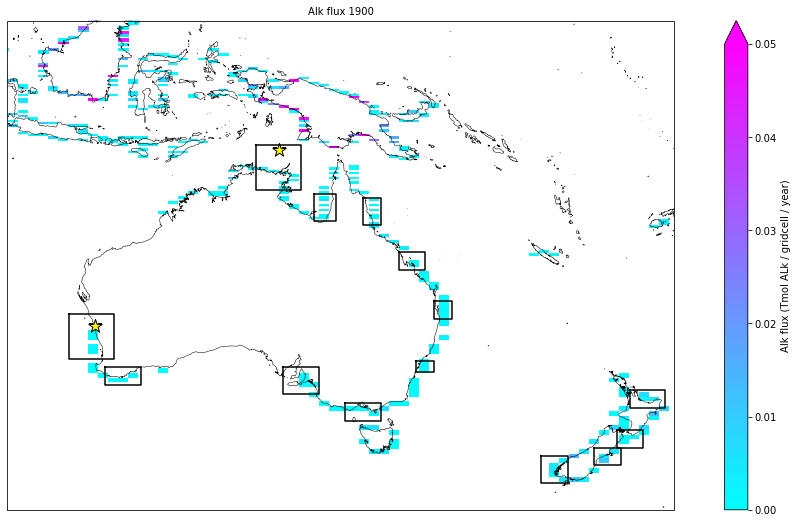

In [30]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([105, 180, -50, 5], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box14_lonmin,box14_lonmax,box14_lonmax,box14_lonmin,box14_lonmin]
lat_pts = [box14_latmax,box14_latmax,box14_latmin,box14_latmin,box14_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box15_lonmin,box15_lonmax,box15_lonmax,box15_lonmin,box15_lonmin]
lat_pts = [box15_latmax,box15_latmax,box15_latmin,box15_latmin,box15_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box69_lonmin,box69_lonmax,box69_lonmax,box69_lonmin,box69_lonmin]
lat_pts = [box69_latmax,box69_latmax,box69_latmin,box69_latmin,box69_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box70_lonmin,box70_lonmax,box70_lonmax,box70_lonmin,box70_lonmin]
lat_pts = [box70_latmax,box70_latmax,box70_latmin,box70_latmin,box70_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box71_lonmin,box71_lonmax,box71_lonmax,box71_lonmin,box71_lonmin]
lat_pts = [box71_latmax,box71_latmax,box71_latmin,box71_latmin,box71_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box72_lonmin,box72_lonmax,box72_lonmax,box72_lonmin,box72_lonmin]
lat_pts = [box72_latmax,box72_latmax,box72_latmin,box72_latmin,box72_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box73_lonmin,box73_lonmax,box73_lonmax,box73_lonmin,box73_lonmin]
lat_pts = [box73_latmax,box73_latmax,box73_latmin,box73_latmin,box73_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box74_lonmin,box74_lonmax,box74_lonmax,box74_lonmin,box74_lonmin]
lat_pts = [box74_latmax,box74_latmax,box74_latmin,box74_latmin,box74_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box75_lonmin,box75_lonmax,box75_lonmax,box75_lonmin,box75_lonmin]
lat_pts = [box75_latmax,box75_latmax,box75_latmin,box75_latmin,box75_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box76_lonmin,box76_lonmax,box76_lonmax,box76_lonmin,box76_lonmin]
lat_pts = [box76_latmax,box76_latmax,box76_latmin,box76_latmin,box76_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box77_lonmin,box77_lonmax,box77_lonmax,box77_lonmin,box77_lonmin]
lat_pts = [box77_latmax,box77_latmax,box77_latmin,box77_latmin,box77_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box78_lonmin,box78_lonmax,box78_lonmax,box78_lonmin,box78_lonmin]
lat_pts = [box78_latmax,box78_latmax,box78_latmin,box78_latmin,box78_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box79_lonmin,box79_lonmax,box79_lonmax,box79_lonmin,box79_lonmin]
lat_pts = [box79_latmax,box79_latmax,box79_latmin,box79_latmin,box79_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box80_lonmin,box80_lonmax,box80_lonmax,box80_lonmin,box80_lonmin]
lat_pts = [box80_latmax,box80_latmax,box80_latmin,box80_latmin,box80_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### Create a dataset that has each region mask as a variable name

In [156]:
ds_region_masks = xr.Dataset()

for regnum in np.arange(1,101,1):
    #print(eval("box" + str(regnum)+'_latmin'))
    ds_region_masks['Reg_{0}'.format(regnum)] = ones.where(lats<eval("box" + str(regnum)+'_latmax')).where(lats>eval("box" + str(regnum)+'_latmin')).where(lons_norm<eval("box" + str(regnum)+'_lonmax')).where(lons_norm>eval("box" + str(regnum)+'_lonmin'))

####### Let's look where all our regions are at on a global map

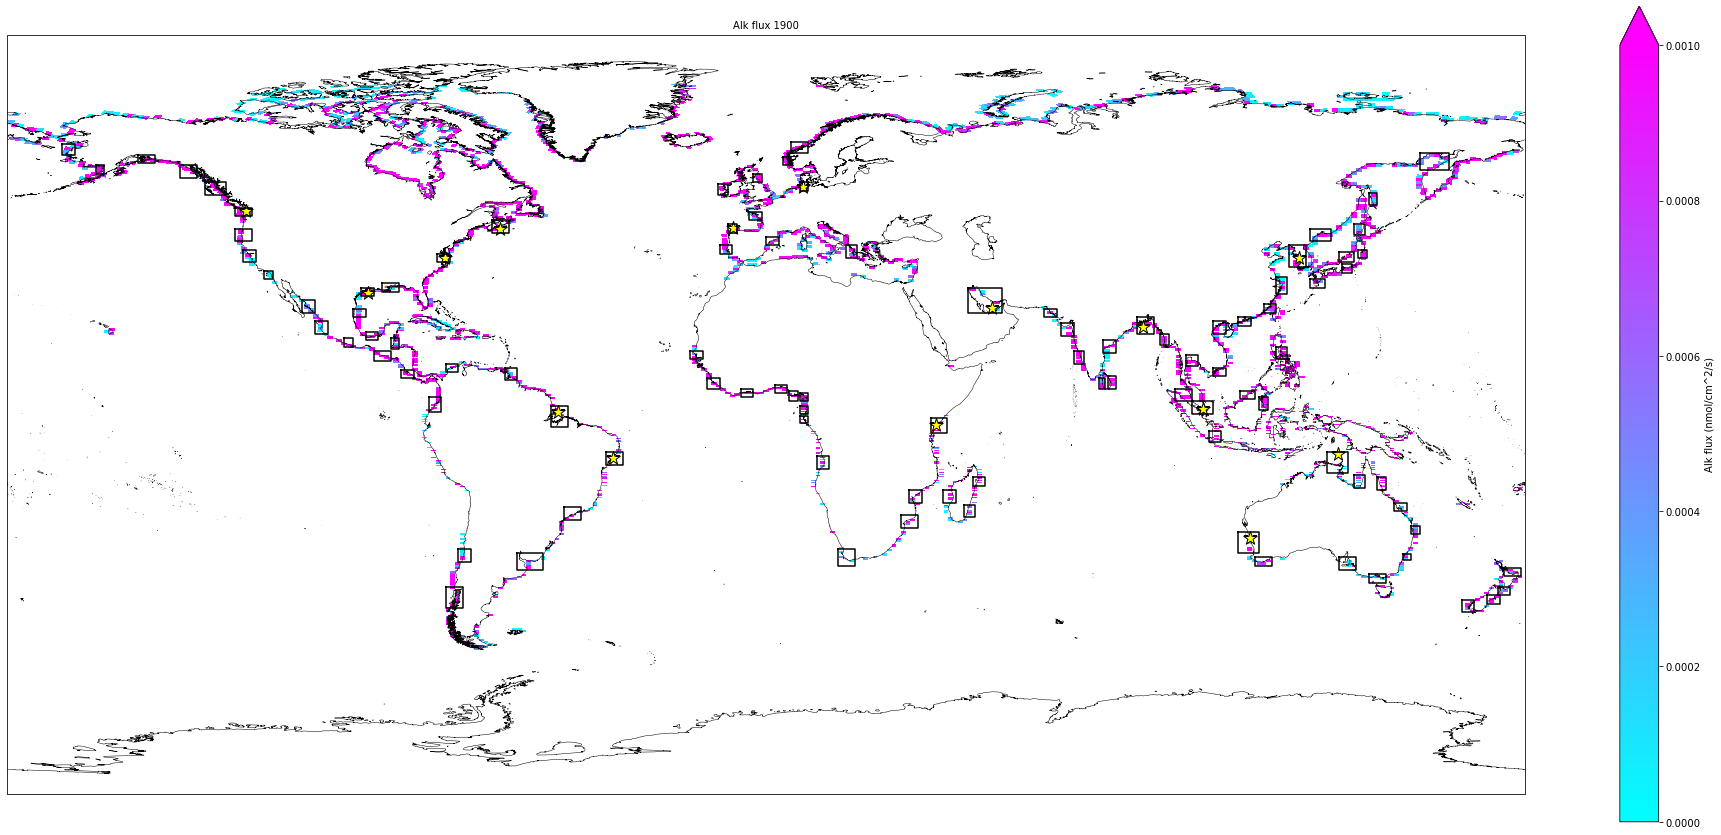

In [157]:
fig = plt.figure(figsize=(34,15))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0)
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.001, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

for regnum in np.arange(1,101,1):
    lon_pts = [eval("box" + str(regnum)+'_lonmin'),eval("box" + str(regnum)+'_lonmax'),eval("box" + str(regnum)+'_lonmax'),eval("box" + str(regnum)+'_lonmin'),eval("box" + str(regnum)+'_lonmin')]
    lat_pts = [eval("box" + str(regnum)+'_latmax'),eval("box" + str(regnum)+'_latmax'),eval("box" + str(regnum)+'_latmin'),eval("box" + str(regnum)+'_latmin'),eval("box" + str(regnum)+'_latmax')]
    ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol/cm^2/s)')

fig.savefig('/glade/work/kristenk/figs/River_map.png', bbox_inches='tight', dpi=300, format='png');


### Cycle through regions and distribute 1/100 of total 206.6 Tmol Alk into each of 100 regions

In [158]:
tot_regs = 100
total_OAE_alk = 206.6 #Tmol
alk_per_reg_Tmol = total_OAE_alk/tot_regs
alk_per_reg_Tmol

2.066

In [159]:
# count gridcells
num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks['Reg_2'].values))

# divide extra alk equally among the region's gridcells
alk_to_add_per_gc = alk_per_reg_Tmol/num_gc_reg

# masks are ones just where the region is.. so this puts the amount of alk per gridcell on the global grid
tmp = ds_region_masks['Reg_2'] * alk_to_add_per_gc 

### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks['Reg_2']==1) * 86400 * 365)


In [160]:
# count gridcells
num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks['Reg_1'].values))

# divide extra alk equally among the region's gridcells
alk_to_add_per_gc = alk_per_reg_Tmol/num_gc_reg

# masks are ones just where the region is.. so this puts the amount of alk per gridcell on the global grid
tmp = ds_region_masks['Reg_1'] * alk_to_add_per_gc 

### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks['Reg_1']==1) * 86400 * 365)


In [161]:
regions = []

for reg in np.arange(1,tot_regs+1,1):
    
    regions = regions + ['Reg_' + str(reg)]

In [162]:
zeros = np.full((384,320),0,dtype=int)
zeros = xr.DataArray(zeros, dims=('nlat','nlon'))

i = 0

for reg in regions:
    
    ## count gridcells
    num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0).values))

    print(reg, ': ',num_gc_reg)
    
    ## divide extra alk equally among the region's gridcells
    alk_to_add_per_gc = alk_per_reg_Tmol/num_gc_reg

    # masks are ones just where the region is.. so this puts the amount of alk per gridcell on the global grid
    tmp = ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * alk_to_add_per_gc
    
    ### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
    tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks[reg]==1).where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * 86400. * 365.)

    if i == 0:

        add_alk_fluxes = zeros + tmp2.fillna(0)

    else:
        add_alk_fluxes = add_alk_fluxes.fillna(0) + tmp2.fillna(0)
        
    i = i + 1

add_alk_fluxes = add_alk_fluxes.where(ds_grid.REGION_MASK > 0)

Reg_1 :  3
Reg_2 :  3
Reg_3 :  3
Reg_4 :  4
Reg_5 :  6
Reg_6 :  6
Reg_7 :  2
Reg_8 :  3
Reg_9 :  4
Reg_10 :  5
Reg_11 :  3
Reg_12 :  5
Reg_13 :  6
Reg_14 :  4
Reg_15 :  7
Reg_16 :  5
Reg_17 :  5
Reg_18 :  5
Reg_19 :  2
Reg_20 :  5
Reg_21 :  3
Reg_22 :  11
Reg_23 :  5
Reg_24 :  6
Reg_25 :  5
Reg_26 :  9
Reg_27 :  2
Reg_28 :  2
Reg_29 :  3
Reg_30 :  5
Reg_31 :  4
Reg_32 :  3
Reg_33 :  5
Reg_34 :  5
Reg_35 :  4
Reg_36 :  3
Reg_37 :  3
Reg_38 :  3
Reg_39 :  4
Reg_40 :  2
Reg_41 :  4
Reg_42 :  4
Reg_43 :  2
Reg_44 :  6
Reg_45 :  3
Reg_46 :  3
Reg_47 :  3
Reg_48 :  6
Reg_49 :  3
Reg_50 :  5
Reg_51 :  3
Reg_52 :  3
Reg_53 :  6
Reg_54 :  5
Reg_55 :  4
Reg_56 :  4
Reg_57 :  4
Reg_58 :  6
Reg_59 :  6
Reg_60 :  5
Reg_61 :  4
Reg_62 :  4
Reg_63 :  3
Reg_64 :  4
Reg_65 :  5
Reg_66 :  3
Reg_67 :  5
Reg_68 :  6
Reg_69 :  6
Reg_70 :  6
Reg_71 :  2
Reg_72 :  4
Reg_73 :  2
Reg_74 :  3
Reg_75 :  4
Reg_76 :  3
Reg_77 :  3
Reg_78 :  3
Reg_79 :  3
Reg_80 :  5
Reg_81 :  2
Reg_82 :  2
Reg_83 :  3
Reg_84 :  3


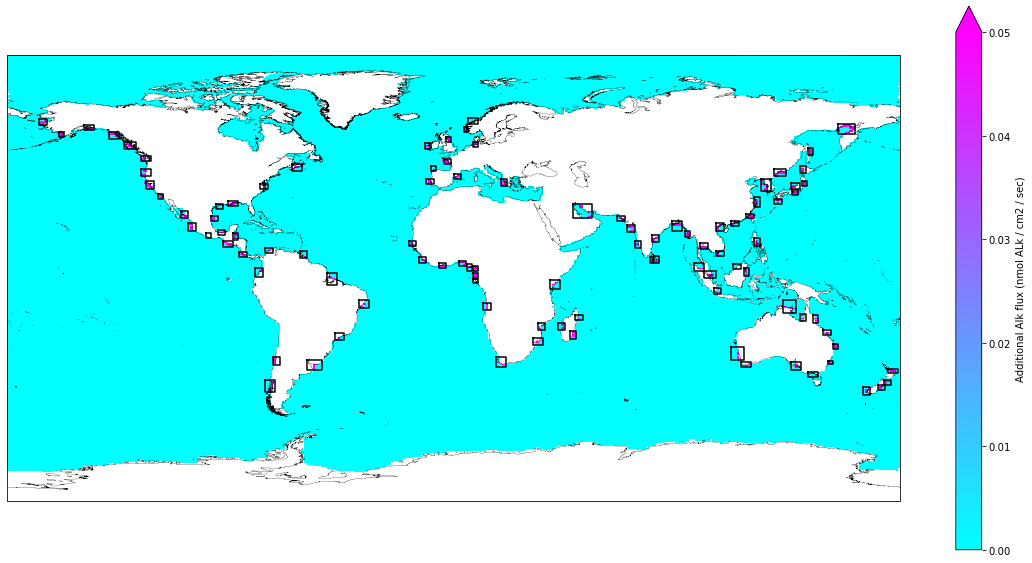

In [163]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.25)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  add_alk_fluxes)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

for regnum in np.arange(1,101,1):
    lon_pts = [eval("box" + str(regnum)+'_lonmin'),eval("box" + str(regnum)+'_lonmax'),eval("box" + str(regnum)+'_lonmax'),eval("box" + str(regnum)+'_lonmin'),eval("box" + str(regnum)+'_lonmin')]
    lat_pts = [eval("box" + str(regnum)+'_latmax'),eval("box" + str(regnum)+'_latmax'),eval("box" + str(regnum)+'_latmin'),eval("box" + str(regnum)+'_latmin'),eval("box" + str(regnum)+'_latmax')]
    ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Additional Alk flux (nmol ALk / cm2 / sec)')

fig.savefig('/glade/work/kristenk/figs/extra_alk_fluxes.png', bbox_inches='tight', dpi=300, format='png');

### Total it back up and make sure I get 206.6 Tmol of alk per year

In [164]:
tmp = add_alk_fluxes * area #nmol/s/gridcell
tmp2 = tmp  * 1e-9 * 1e-12 * 86400 * 365
tmp3 = tmp2.sum(dim=('nlon','nlat'))
tmp3.values

array(206.6)

### Figure out how to modify CFTime dimension

In [165]:
ds_globalnews.time

<xarray.DataArray 'time' (time: 21)>
array([cftime.DatetimeNoLeap(1900, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1905, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1910, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1915, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1925, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1930, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1935, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1940, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1945, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1950, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1955, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1960, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1965, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1970, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1975, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1985, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1990, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1995, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1900-07-01 12:00:00 ... 2000-07-01 12:00:00
Attributes:
    long_name:  time

In [166]:
test = [cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0),cftime.DatetimeNoLeap(2005, 7, 1, 12, 0, 0, 0)]
test = xr.DataArray(test,dims=('time'))
test

<xarray.DataArray (time: 2)>
array([cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 7, 1, 12, 0, 0, 0)], dtype=object)
Dimensions without coordinates: time

### create a 3D array of Alk additions with (time, lat, lon) spanning 1900 to 2100, every 5 years

In [167]:
xlen = len(ds_grid.nlon)
ylen = len(ds_grid.nlat)

### How much Alk to each during ramp up?

In [169]:
alk_step = total_OAE_alk/4

alk_step

51.65

In [170]:
## initialize the empty array
alk_adds = np.full((41,ylen,xlen),0,dtype=float)
alk_adds_tot = np.full((41,ylen,xlen),0,dtype=float)

glb_alk_adds = np.full((41),0,dtype=float)
glb_alk_adds_tot = np.full((41),0,dtype=float)

## cycling from 1900 to 2100, put alk addition every 5 years

t = 0 # time slice counter

for year in np.arange(1900,2105,5):

    print(year,t)

    ### create zero data array to start this year with, this could be replaced with actual global news alk array for this particular year
    zeros = np.full((384,320),0,dtype=int)
    zeros = xr.DataArray(zeros, dims=('nlat','nlon'))

    i = 0 #counter for regions
    
    ## how many Tmol alk to be distributed?
    if year <= 2025:
        tot_alk = 0
    elif year == 2030:
        tot_alk = alk_step
    elif year == 2035:
        tot_alk = 2 * alk_step
    elif year == 2040:
        tot_alk = 3 * alk_step
    elif year >= 2045:
        tot_alk = total_OAE_alk

    tot_alk_per_reg = tot_alk/tot_regs

    ## cycle through regions and distribute alkalinity
    for reg in regions:
        
        ## count gridcells
        num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0).values))
        
        ## figure out how much to add to each gridcell for this region 
        alk_to_add_per_gc = tot_alk_per_reg/num_gc_reg

        #print(reg, ': ',num_gc_reg,' gridcells so ', alk_to_add_per_gc, ' of alk per gridcell per year')
        
        tmp = ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * alk_to_add_per_gc
        ### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
        
        tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks[reg]==1).where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * 86400. * 365.)
    
        if i == 0:
    
            add_alk_fluxes = zeros + tmp2.fillna(0)
    
        else:
            add_alk_fluxes = add_alk_fluxes.fillna(0) + tmp2.fillna(0)
            
        #add_alk_fluxes = add_alk_fluxes.where(ds_grid.REGION_MASK > 0)
        i = i + 1

    alk_adds[t,:,:] = add_alk_fluxes

    if year <= 2000:
        alk_adds_tot[t,:,:] = ds_globalnews.alk_riv_flux.isel(time=t).values + add_alk_fluxes
    else:
        alk_adds_tot[t,:,:] = ds_globalnews.alk_riv_flux.isel(time=20).values + add_alk_fluxes
    

    #### total up to see how much alk adding this year

    tmp = alk_adds[t,:,:] * area #nmol/s/gridcell
    tmp2 = tmp  * 1e-9 * 1e-12 * 86400 * 365
    tmp3 = tmp2.sum(dim=('nlon','nlat'))
    print('adding ', tmp3.values, ' of Alk this year')
    glb_alk_adds[t] = tmp3.values

    tmp = alk_adds_tot[t,:,:] * area #nmol/s/gridcell
    tmp2 = tmp  * 1e-9 * 1e-12 * 86400 * 365
    tmp3 = tmp2.sum(dim=('nlon','nlat'))
    print('Total alk going into ocean: ', tmp3.values, ' this year')
    glb_alk_adds_tot[t] = tmp3.values
    
    t = t + 1

alk_adds = xr.DataArray(alk_adds,dims=('time','nlat','nlon'))
alk_adds_tot = xr.DataArray(alk_adds_tot,dims=('time','nlat','nlon'))
glb_alk_adds = xr.DataArray(glb_alk_adds,dims=('time'))
glb_alk_adds_tot = xr.DataArray(glb_alk_adds_tot,dims=('time'))

1900 0
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1905 1
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1910 2
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1915 3
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1920 4
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1925 5
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1930 6
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1935 7
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1940 8
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1945 9
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1950 10
adding  0.0  of Alk this year
Total alk go

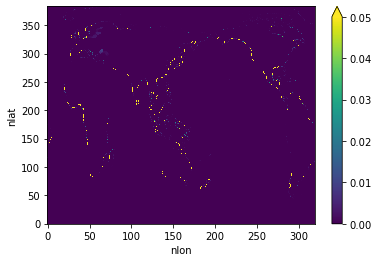

In [171]:
alk_adds_tot.isel(time=27).plot(vmin=0,vmax=0.05)

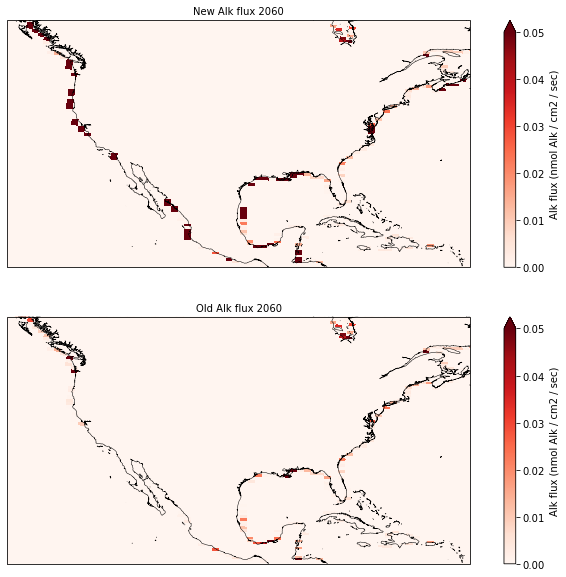

In [172]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-135, -60, 15, 55], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('New Alk flux 2060', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_adds_tot.isel(time=32))
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='Reds',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol Alk / cm2 / sec)')

ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-135, -60, 15, 55], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Old Alk flux 2060', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_globalnews.alk_riv_flux.isel(time=20))
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='Reds',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol Alk / cm2 / sec)')


### Prepare a netCDF to be written out, all other fields remain exactly the same through 2100

In [173]:
ds_globalnews.time[20]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2000-07-01 12:00:00
Attributes:
    long_name:  time

In [174]:
## what time-varying variables are in the netcdf?

variables2d = ['KMT','TAREA','pp_riv_flux_gnews','din_riv_flux_gnews','dop_riv_flux_gnews',
               'pn_riv_flux_gnews','dip_riv_flux_gnews','don_riv_flux_gnews']

variables3d = ['dsi_riv_flux','discharge_riv_flux_IMAGE_GNM','pn_riv_flux','Pload_riv_flux_IMAGE_GNM',
               'Nload_riv_flux_IMAGE_GNM','doc_riv_flux','dip_riv_flux','dop_riv_flux','dic_riv_flux',
               'din_riv_flux','don_riv_flux','pp_riv_flux','dfe_riv_flux','poc_riv_flux']

alk_var = 'alk_riv_flux'

In [175]:
len(variables2d) + len(variables3d) + 1 #(for alk var)

23

#### first add 2d vars

In [176]:
ds_out = xr.Dataset()

for var in variables2d:
    ds_out[var] = ds_globalnews[var]

In [177]:
ds_out.attrs = ds_globalnews.attrs

In [178]:
ds_out.attrs['modifications'] =  'adding extra alkalinity to natural alkalinity river fluxes for OAE experiments'
ds_out.attrs['notes2'] = 'modified by Kristen Krumhardt, October 23, 2025'

### Now add the 3d fields

In [179]:
variables3d[0]

'dsi_riv_flux'

In [180]:
for var in variables3d: #this list does NOT have alk in it, will add afterwards
    print(var)
    var_array = np.full((41,ylen,xlen),0,dtype=float)
    
    t = 0 # time slice counter
    
    for year in np.arange(1900,2105,5):
    
        #print(year,t)
        
        if year <= 2000:
            var_array[t,:,:] = ds_globalnews[var].isel(time=t).values
        else:
            var_array[t,:,:] = ds_globalnews[var].isel(time=20).values
        
        t = t + 1

    ## now turn it into an xarray, add the same attributes as the original var and then add it ds_out
    var_array = xr.DataArray(var_array,dims=('time','nlat','nlon'))

    var_array.attrs = ds_globalnews[var].attrs

    ds_out[var] = var_array

####### Now add the new alkalinity!!!

ds_out[alk_var] = alk_adds_tot
ds_out[alk_var].attrs = ds_globalnews[alk_var].attrs
ds_out[alk_var].attrs['notes'] = 'added alk for OAE experiments'


dsi_riv_flux
discharge_riv_flux_IMAGE_GNM
pn_riv_flux
Pload_riv_flux_IMAGE_GNM
Nload_riv_flux_IMAGE_GNM
doc_riv_flux
dip_riv_flux
dop_riv_flux
dic_riv_flux
din_riv_flux
don_riv_flux
pp_riv_flux
dfe_riv_flux
poc_riv_flux


In [181]:
ds_out

<xarray.Dataset>
Dimensions:                       (nlat: 384, nlon: 320, time: 41)
Coordinates:
    TLAT                          (nlat, nlon) float64 ...
    TLONG                         (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon, time
Data variables: (12/23)
    KMT                           (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
    pp_riv_flux_gnews             (nlat, nlon) float64 ...
    din_riv_flux_gnews            (nlat, nlon) float64 ...
    dop_riv_flux_gnews            (nlat, nlon) float64 ...
    pn_riv_flux_gnews             (nlat, nlon) float64 ...
    ...                            ...
    din_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    don_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    pp_riv_flux                   (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    dfe_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    poc_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    alk_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    note:           Created by M. Long (NCAR) 2017-04-25
    source:         Blend of GlobalNEWS and IMAGE-GNM data: GlobalNEWS: https...
    assumptions:    Dissolved inorganic carbon (DIC) in freshwater inputs is ...
    mapping:        Nutrient file on runoff grid: /glade/p/work/mclong/cesm_i...
    procedure:      Data sets were interpolated to the runoff grid, then mapp...
    modifications:  adding extra alkalinity to natural alkalinity river fluxe...
    notes2:         modified by Kristen Krumhardt, October 23, 2025

### Now make a CFTime time dimension

In [182]:
time_dim = np.empty((41), dtype=object)

t = 0 # time slice counter

for year in np.arange(1900,2105,5):

    time_dim[t] = cftime.DatetimeNoLeap(year, 7, 1, 12, 0, 0, 0)

    t = t + 1

time_dim = xr.DataArray(time_dim,dims=('time'))
time_dim

<xarray.DataArray (time: 41)>
array([cftime.DatetimeNoLeap(1900, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1905, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1910, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1915, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1925, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1930, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1935, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1940, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1945, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1950, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1955, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1960, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1965, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1970, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1975, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1985, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1990, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1995, 7, 1, 12, 0, 0, 0),
...
       cftime.DatetimeNoLeap(2005, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2020, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2025, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2030, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2035, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2040, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2045, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2050, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2055, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2060, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2065, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2070, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2075, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2080, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2085, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2090, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2095, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 7, 1, 12, 0, 0, 0)], dtype=object)
Dimensions without coordinates: time

In [183]:
ds_out['time'] = time_dim

ds_out['time'].attrs = ds_globalnews.time.attrs

In [184]:
ds_out['time'].attrs

{'long_name': 'time'}

In [185]:
ds_out

<xarray.Dataset>
Dimensions:                       (nlat: 384, nlon: 320, time: 41)
Coordinates:
    TLAT                          (nlat, nlon) float64 ...
    TLONG                         (nlat, nlon) float64 ...
  * time                          (time) object 1900-07-01 12:00:00 ... 2100-...
Dimensions without coordinates: nlat, nlon
Data variables: (12/23)
    KMT                           (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
    pp_riv_flux_gnews             (nlat, nlon) float64 ...
    din_riv_flux_gnews            (nlat, nlon) float64 ...
    dop_riv_flux_gnews            (nlat, nlon) float64 ...
    pn_riv_flux_gnews             (nlat, nlon) float64 ...
    ...                            ...
    din_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    don_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    pp_riv_flux                   (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    dfe_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    poc_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    alk_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    note:           Created by M. Long (NCAR) 2017-04-25
    source:         Blend of GlobalNEWS and IMAGE-GNM data: GlobalNEWS: https...
    assumptions:    Dissolved inorganic carbon (DIC) in freshwater inputs is ...
    mapping:        Nutrient file on runoff grid: /glade/p/work/mclong/cesm_i...
    procedure:      Data sets were interpolated to the runoff grid, then mapp...
    modifications:  adding extra alkalinity to natural alkalinity river fluxe...
    notes2:         modified by Kristen Krumhardt, October 23, 2025

In [186]:
filename='riv_nut.gnews_gnm.gx1v7_nn_open_ocean_nnsm_e1000r300_marginal_sea.OAE_5GtCO2exp.20251023.nc'

ds_out.to_netcdf('/glade/derecho/scratch/kristenk/OAE_experiment_data/'+filename, format="NETCDF4_CLASSIC",mode='w')

# format: The netCDF format to use (e.g., "NETCDF4", "NETCDF4_CLASSIC")